In [1]:
!pip install wget
!pip install spacy_langdetect
!pip install torchtext==0.6.0
!pip install clean-text
!pip install emoji
!pip install tweet-preprocessor
!pip install kaggle

import os
import re
import wget
import shutil
import spacy
import zipfile
import gzip
import json
import time
import random
import numpy as np
import pandas as pd
import collections


import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from spacy_langdetect import LanguageDetector
from spacy.tokens import Doc
from cleantext import clean
import preprocessor as p
import emoji


import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torchtext import data
from torchsummary import summary
from torchtext.data.metrics import bleu_score
from tqdm.autonotebook import tqdm

"""
Ignoring FutureWarning
"""
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ImportWarning)

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9843bd6b2de20cb0c9cf4a8c6454f0a0ec49f8bd242d52e19fb68c3be90e26be
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 1.0MB 9.0MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp36-none-any.whl size=993461 sha256=86acc46aa4352099f09c05cb21a3a7051bbfa2f7cba06b32cb2c32be1834fdb0
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 71kB 4.9MB/s 
     |████████████████████████████████| 1.1MB 14.0MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
     |████████████████████████████████| 71kB 5.5MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
  Created wheel for ftfy: f

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


### **Constants And Required Functions**

**Data Preprocessing**

In [3]:
"""
Device
"""
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


"""
Batch Size, Embedding Size, Hidden Size
"""
BATCH_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, NUM_LAYERS, EPOCHS = 32, 64, 256, 3, 20
"""
Sentence start, end and pad token
"""
SOS_TOKEN, EOS_TOKEN, PAD_TOKEN = "<SOS>", "<EOS>", "<_PADDING_>"

NO_ANSWER_PRESENT = "no answer present"

def textPreprocess(txt):
    """
    Convert to Lowercase and Trim the text
    """
    txt = txt.lower().strip()

    """
    Fix various unicode errors
    transliterate to closest ASCII representation
    """
    txt = clean(txt, fix_unicode=True, to_ascii=True)

    """
    Removing zero-width character
    """
    txt = re.sub(u"\ufe0f", r" ", txt)

    """
    Remove URL
    """
    txt = re.sub(r"https?://[A-Za-z0-9./]*", r" ", txt)

    """
    Remove Specific Special character
    """
    txt = re.sub(r"[-.!?()_]+", r" ", txt)
    """
    Remove charatcter like special characters, punctuations except alphanumeric charatcter.
    """
    txt = re.sub(r"[^0-9a-zA-Z]+", r" ", txt)

    """
    Remove Extra spaces which are appearing from previous processing steps.
   function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
 """
    txt = re.sub(r"\s+", r" ", txt).strip()
    return txt

**Required Directories Creation**

In [4]:
"""
Required functions for directory creation
"""
def check_if_dir_exists(directory):
    """
    Checks if 'directory' exists
    """
    return(os.path.isdir(directory))

def make_dir(directory):
    """
    Create directory
    """
    if not check_if_dir_exists(directory):
        os.mkdir(directory)
        print("Directory %s created successfully." %directory)
    else:
        print("Directory %s exists." %directory)

print("We are in:",os.getcwd())

"""
Required directory creation
"""
chatbot_dir="/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta"
make_dir(chatbot_dir)

os.chdir("/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta")

chatbot_data_dir = chatbot_dir + "/ChatBot_Data/"
make_dir(chatbot_data_dir)

chatbot_result_dir = chatbot_dir + "/ChatBot_Results/"
make_dir(chatbot_result_dir)

chatbot_checkpoint_dir = chatbot_dir + "/ChatBot_Checkpoint/"
make_dir(chatbot_checkpoint_dir)

print(chatbot_data_dir)

We are in: /content
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta exists.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/ exists.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Results/ exists.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Checkpoint/ exists.
/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/


**Dataset Download and Extraction**

In [ ]:
"""
Required functions for dataset download and extraction
"""
def check_if_file_exists(file):
    """
    Checks if 'file' exists
    """
    return os.path.isfile(file)

def extract_zip_file(extract_file, file_name):
    """
    Extract or Unzip the downloaded the Dataset
    """
    if not check_if_dir_exists(extract_file):

        try:
            startTime = time.time()
            print('Extracting all the files now...') 
            with zipfile.ZipFile(file_name, 'r') as zip_file: 
                print('Extracting all the files now...') 
                zip_file.extractall() 
                print('Done!') 
            total_time = time.time()-startTime
            print('Time Taken for extracting all files :', total_time/60,'minutes')
        except FileNotFoundError:
            print('Please make sure file: ' + file_name + ' is present before continuing')
    else:
        print('Data file', extract_file, 'exists.\nWon\'t extract again!')

"""
Based on instrcutions from Kaggle's API on [GitHub](https://github.com/Kaggle/kaggle-api)
Install Kaggle Python API
Go to https://www.kaggle.com/<username>/account and click on "Create New API Token"
This should download a file named kaggle.json
Upload the file to /content/gdrive/My Drive/.kaggle
"""
"""
Data source url
"""
data_source_url='https://www.kaggle.com/thoughtvector/customer-support-on-twitter'
print('Data source url :',data_source_url)

"""
Set environment variable for Kaggle configuration directory
"""
os.environ['KAGGLE_CONFIG_DIR'] = chatbot_data_dir+".kaggle"

"""
Change to directory where we want to download the dataset
We want to download the dataset from the Kaggle project - [Customer Support on Twitter](https://www.kaggle.com/thoughtvector/customer-support-on-twitter)
"""

os.chdir(chatbot_dir)
DATASET = "thoughtvector/customer-support-on-twitter"


"""
Download and Extract Dataset
"""
!kaggle datasets download $DATASET



"""
Unzip the downloaded Dataset
"""
data_filename = chatbot_dir + "/customer-support-on-twitter.zip"
data_dir = chatbot_dir + "/twcs"

extract_zip_file(data_dir, data_filename)

"""
Move twcs to the data directory
"""
shutil.move(chatbot_dir+"/twcs/twcs.csv", chatbot_data_dir+"twcs.csv")

"""
Removing the zip file and sample.csv
"""
os.rmdir("twcs")
os.remove("customer-support-on-twitter.zip")
os.remove("sample.csv")

Data source url : https://www.kaggle.com/thoughtvector/customer-support-on-twitter
 94% 159M/169M [00:04<00:00, 37.4MB/s]
100% 169M/169M [00:04<00:00, 39.5MB/s]
Extracting all the files now...
Extracting all the files now...
Done!
Time Taken for extracting all files : 0.097599458694458 minutes


**Listing Directories**

In [5]:
def list_dir(dir_path):
  """
  List directories for a given path
  """
  print("Directory %s contains : " %dir_path)
  for dir_or_file in os.listdir(dir_path):
    print(dir_or_file)
  print("\n")

"""
List created directories
"""
print('Current directory : ', os.getcwd(),'\n')
list_dir(chatbot_dir)
list_dir(chatbot_data_dir)
list_dir(chatbot_checkpoint_dir)

Current directory :  /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta 

Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta contains : 
ChatBot_Data
ChatBot_Results
ChatBot_Checkpoint
.vector_cache
Images


Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/ contains : 
.kaggle
dev_v2.1.json.gz
dev_v2.1.json
question_asked.tsv
QAWhats.tsv
twcs.csv
QA_Pair.tsv
Apple_QA_Pair.tsv


Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Checkpoint/ contains : 
Results.csv
Apple_QA_Seq2Seq_ChatBot_BestModel.pt
Apple_QA_Seq2Seq_ChatBot.pt
QA_Seq2Seq_ChatBot_BestModel.pt
QA_Seq2Seq_ChatBot.pt




**Data Preprocesssing or Transformation**

In [ ]:
data_df = pd.read_csv(chatbot_data_dir + 'twcs.csv')
data_df.sort_values(by='tweet_id', inplace=True)
print("Shape data_df : ",data_df.shape)
data_df.head()

Shape data_df :  (2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [ ]:
qa_df = data_df[data_df['author_id'] == 'AppleSupport']
qa_df = qa_df[~qa_df['in_response_to_tweet_id'].isnull()]
qa_df = qa_df[['tweet_id', 'text', 'in_response_to_tweet_id']]
qa_df.rename(columns={ 'text': 'answer'}, inplace=True)
qa_df["in_response_to_tweet_id"] = qa_df["in_response_to_tweet_id"].astype('int')

"""
Create QA Pair
"""
def get_question(df, x):
    return df[df['tweet_id'] == x].iloc[0]['text'] if df[df['tweet_id'] == x]['text'].count() != 0 else ''

qa_df['question'] = qa_df["in_response_to_tweet_id"].apply(lambda x: get_question(data_df, x))
qa_df = qa_df.reset_index(drop=True)
qa_df = qa_df[['question', 'answer']]

qa_df["question_len"]= qa_df["question"].apply(len)
qa_df["answer_len"]= qa_df["answer"].apply(len)

qa_df["question_wrd_len"]= qa_df["question"].apply(lambda x: len(x.split( )))
qa_df["answer_wrd_len"]= qa_df["answer"].apply(lambda x: len(x.split( )))

# **Exploratory Data Analysis**

In [ ]:
sns.set_style('darkgrid')

**Distribution of Question and Answer Length**

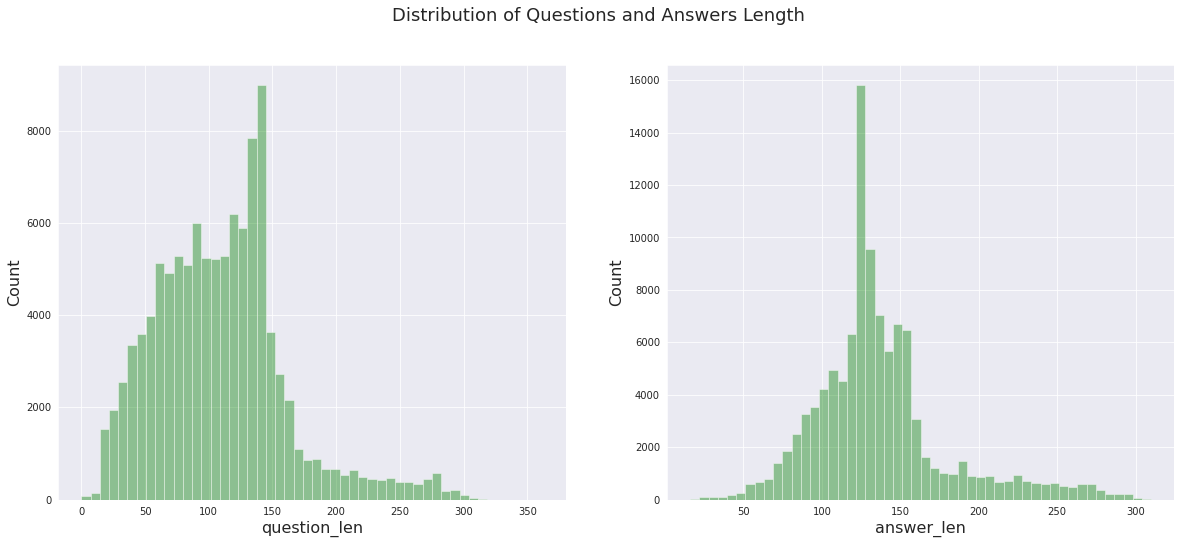

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(8)
fig.suptitle("Distribution of Questions and Answers Length",fontsize=18)
sns.color_palette("rocket_r")
for i, column in enumerate(["question_len","answer_len"]):
    axes[i].set_xlabel(column, fontsize = 16)
    axes[i].set_ylabel(ylabel="Count",fontsize=16)
    
    sns.distplot(qa_df[column], kde=False, ax=axes[i], color="g", bins=50)

**Distribution of Number of Words in Question and Answer**

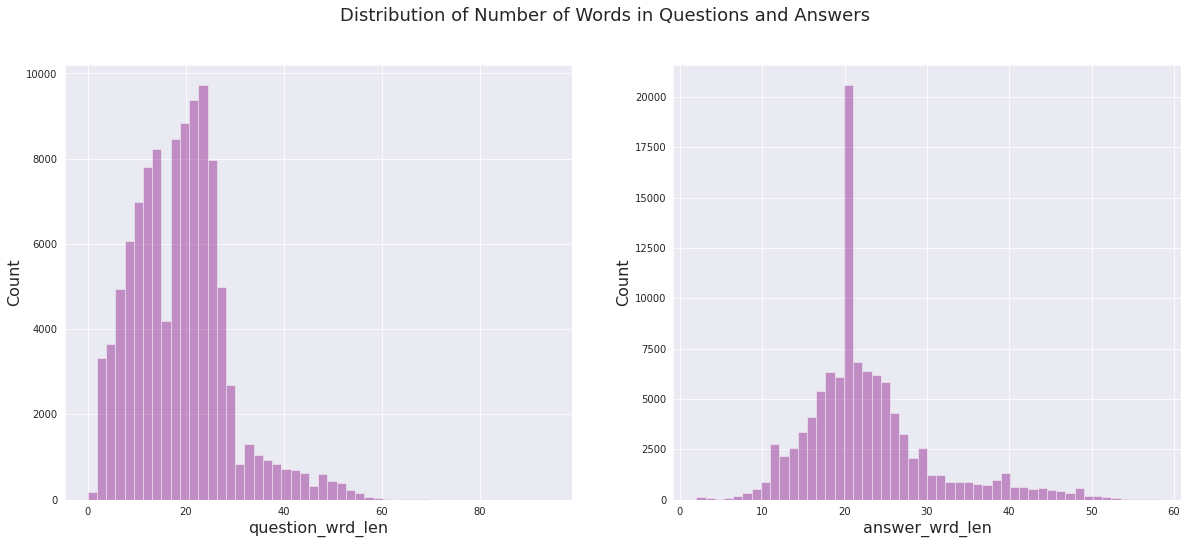

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(20)
fig.set_figheight(8)
fig.suptitle("Distribution of Number of Words in Questions and Answers",fontsize=18)

for i, column in enumerate(["question_wrd_len","answer_wrd_len"]):
    axes[i].set_xlabel(column, fontsize = 16)
    axes[i].set_ylabel(ylabel="Count",fontsize=16)
    
    sns.distplot(qa_df[column], kde=False, ax=axes[i], color="purple", bins=50)   

In [ ]:
def qa_preprocess(sentence):
    """
    Takes in a string of question and answer, then performs the following:
    1. Remove HTML tag from sentence
    2. Remove URLs from sentence
    3. Make entire sentence lowercase
    4. Split the sentence in words
    5. Remove all punctuation
    6. Remove empty strings from sentence
    7. Remove all stopwords
    8. Returns a list of the cleaned sentence after jioning them back to a sentence
    """
    en_stops = set(stopwords.words("english"))
    
    """
    Removing HTML tag from sentence
    """
    clean = re.compile("<.*?>")
    sentence_without_tag = re.sub(clean, "", sentence) 
    
    
    """
    Removing URLs
    """
    sentence_without_tag_and_url = re.sub(r"http\S+", "", sentence_without_tag)
    
    sentence_without_tag_and_url = re.sub(r"www\S+", "", sentence_without_tag)
    
    """
    Make entire string lowercase
    """
    sentence_lowercase = sentence_without_tag_and_url.lower()
    
    """
    Split string into words
    """
    list_of_words = word_tokenize(sentence_lowercase)
    
    
    """
    Remove punctuation
    Checking characters to see if they are in punctuation
    """

    list_of_words_without_punctuation=["".join(this_char for this_char in this_string if (this_char in string.ascii_lowercase))for this_string in list_of_words]
     
    
    """
    Remove empty strings
    """
    list_of_words_without_punctuation = list(filter(None, list_of_words_without_punctuation))
    
    
    """
    Remove any stopwords
    """
  
    filtered_word_list = [w for w in list_of_words_without_punctuation if w not in en_stops] 
    
    """
    Returns a list of the cleaned sentence after jioning them back to a sentence
    """
    return " ".join(filtered_word_list)

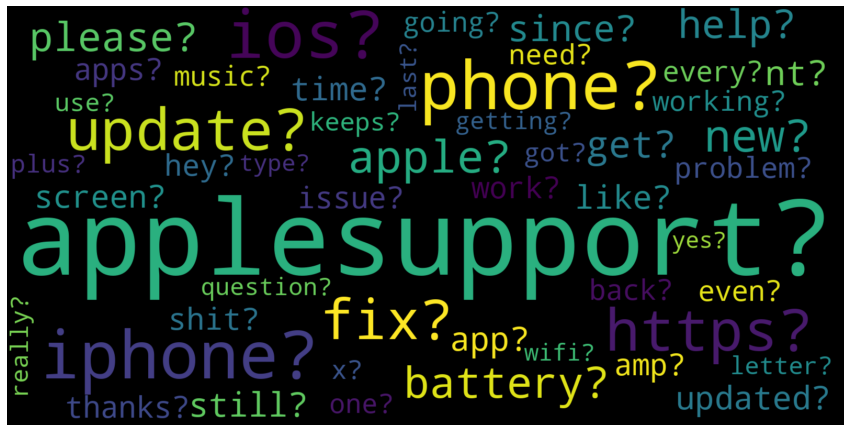

In [ ]:
qa_df["clean_question"] = qa_df["question"].apply(qa_preprocess) 

questions = qa_df["clean_question"].str.cat(sep=' ')

"""
Function to split sentence into word
"""
tokens = word_tokenize(questions)
question_tokens = []
for token in tokens:
    question_tokens.append(token+"?")


frequency_distribution = nltk.FreqDist(question_tokens)

def getWordCloud(frequency_dist,color):
    stopWords = set(STOPWORDS)
    wordCloud = WordCloud(background_color=color,
                          stopwords=stopWords,
                          width=1600,
                          height=800,
                          random_state=21,
                          max_words=50,
                          max_font_size=200).generate_from_frequencies(frequency_dist)
    
    plt.figure(figsize=(15, 10))
    plt.axis("off")
    plt.imshow(wordCloud, interpolation="bilinear")

getWordCloud(frequency_distribution,"black")

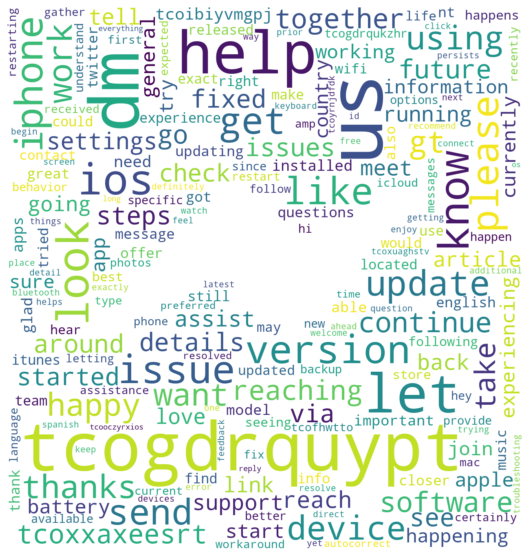

In [ ]:
qa_df["clean_answer"] = qa_df["answer"].apply(qa_preprocess) 

answers = qa_df["clean_answer"].str.cat(sep=" ")

"""
Function to split sentence into word
"""
tokens = word_tokenize(answers)

frequency_distribution = nltk.FreqDist(tokens)

directory = os.getcwd()
mask = np.array(Image.open(os.path.join(directory, "Images/QAB.png")))

wordCloud = WordCloud(background_color="white", mask=mask).generate_from_frequencies(frequency_distribution)

plt.figure(figsize=(15,10))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Carry out some additional cleaning and formating for applying seq2seq**

[preprocessor](https://pypi.org/project/tweet-preprocessor/)

Carry out pre-processing using preprocessor library : 
* Cleaning, Tokenizing, Parsing
* Convertion of  url and hashtag
* Remove emojis, reserved words, smiley and numbers, punctuation 


In [ ]:
def txt_process(txt):
    """
    Cleaning, tokenizing and parsing using preprocessor library.
    """
    p.set_options(p.OPT.EMOJI, p.OPT.MENTION, p.OPT.RESERVED, p.OPT.SMILEY, p.OPT.NUMBER)
    txt = p.clean(txt)
    
    """
    Convertion of url and hashtag.
    """
    p.set_options(p.OPT.HASHTAG, p.OPT.URL) 
    txt = p.tokenize(txt)
    txt = re.sub(r'\$HASHTAG\$', '<hashtag>', txt)
    txt = re.sub(r'\$URL\$', '<url>', txt)
    
    """
    Remove emojis.
    """
    txt = re.sub(emoji.get_emoji_regexp(), '', txt)
    txt = re.sub(u'\ufe0f', '', txt)
    
    """
    Previous cleaning steps cause multiple empty spaces. Replace them with one empty space.
    """
    txt = re.sub(r' +', ' ', txt)
    txt = re.sub(r'&gt;', '>', txt)
    txt = re.sub(r'&lt;', '<', txt)

    return txt.strip()



qa_pair_df = qa_df[['question','answer']]

"""
Clean twitter data
"""
qa_pair_df.loc[:,'question'] = qa_pair_df["question"].apply(txt_process)
qa_pair_df.loc[:,'answer'] = qa_pair_df['answer'].apply(txt_process)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## **Detecting whether the text data are proper English Language or not**

[spacy-langdetect](https://spacy.io/universe/project/spacy-langdetect)


In [ ]:
nlp = spacy.load('en')
language_detector = LanguageDetector()
nlp.add_pipe(language_detector)

def english_language_detection(txt):
    """
    Detecting whether the text data are proper English Language or not.
    If not then assigning empty string to it.
    """
    doc = nlp(txt)
    """
    doc : {'language': 'ro', 'score': 0.8571400249240736}
    """
    return txt if doc._.language['language']=='en' and doc._.language['score'] >= 0.80  else ''
        
"""
Applying the above english_language_detection function to question and answer
"""
start_time=time.time()
qa_pair_df.loc[:,'question'] = qa_pair_df['question'].apply(english_language_detection)
total_time=time.time() - start_time
print('question total time : ',total_time/60,' minutes')

start_time=time.time()
qa_pair_df.loc[:,'answer'] = qa_pair_df['answer'].apply(english_language_detection)
total_time=time.time() - start_time
print('answer total time : ',total_time/60,' minutes')

"""
After detection removing non english text which are assigned to empty string
"""
qa_pair_df = qa_pair_df[~(qa_pair_df['question'] == '') & ~(qa_pair_df['answer'] == '')]
qa_pair_df = qa_pair_df[~(qa_pair_df['question'] == '.') & ~(qa_pair_df['answer'] == '.')]

qa_pair_df.drop_duplicates()
print('Shape of Data : ',qa_pair_df.shape)
qa_pair_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1783: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


question total time :  32.21268575986226  minutes
answer total time :  33.401895240942636  minutes
Shape of Data :  (96724, 2)


,question,answer
1,The newest update. I made sure to download it ...,Lets take a closer look into this issue. Selec...
2,Tried resetting my settings .. restarting my p...,Let's go to DM for the next steps. DM us here:...
3,This is what it looks like <url>,Any steps tried since it started last night?
4,I have an iPhone Plus and yes I do,That's great it has iOS as we can rule out bei...
5,I need answers because its annoying,We'd like to look into this with you. Which mo...


## **Save the processed Data For Future Use**

In [ ]:
qa_pair_df.to_csv(chatbot_data_dir + 'Apple_QA_Pair.tsv', sep='\t', index=False)
print("Data dir "+chatbot_data_dir)

Data dir /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/


## **Dataset and  DataLoader Creation**

***Seq2Seq algorithm*** trains a denoising auto-encoder over sequences. It takes as input a sequence like $\boldsymbol{Q} = \boldsymbol{q}_1, \boldsymbol{q}_2, \ldots, \boldsymbol{q}_T$, and generates a new sequence $\boldsymbol{A} = \boldsymbol{a}_1, \boldsymbol{a}_2, \ldots, \boldsymbol{a}_{T'}$ as output. These sequences might not be same i.e. (q𝑗≠a𝑗) and might be of different lengths so, $T \neq T'$. This training approach is called a denoising auto-encoder because the question sequence $Q$ gets mapped to some related answer sequence(answer) $A$, as if $Q$ was a "noisy" version of $A$. There is no one-to-one relationship between question and answer. This appraoch uses sequences which have a temporal component to it. As in, one word follows another to give proper meanig to the sentence. As a result they usually involve an RNN which are good with learning such sequential data. The EncoderRNN takes in $Q$, and produces a final hidden state activation $\boldsymbol{h}_T$, which the AttentionDecoderRNN takes as input to produce a new sequence $A$.

In this project, I have created question and answer pairs and a vocabulary for the seq2seq model from the dataset chosen. 

***Features of vocabulary :***

* Vocabulary dictionary assigns each unique string or token to its own unique ID
* Not every sequence will be of the same length. Therefore, I use `<_PADDING_>` to pad the sequence to length of the longest sequence. In this way each sequence will be of the same length and allows me to denote sequences in a tensor.
* To indicate _begining of sequence_ and _an end of sequence_ I used the tokens `<SOS>` and `<EOS>` respectively. This helps the model by indicatng when to stop generating the output sequence even when the outputs have differing lengths. Shorter inputs will be padded with the `PAD_TOKEN` value to make sequences of same length.

`collate` takes the inputs that are of different lengths and creates one larger batch out of them. It will return a set of nested tuples, $((\boldsymbol{Q}, \boldsymbol{A}), \boldsymbol{A})$. This is required because `seq2seq_model` requires both $\boldsymbol{Q}$ and $\boldsymbol{A}$ during training. The `train_seq2seq` function expects tuples of $(question, answer)$

$$(\underbrace{(\boldsymbol{Q}, \boldsymbol{A})}_{\text{input}}, \underbrace{\boldsymbol{A}}_{\text{output}})$$

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_seed(915)

"""
QA Pair, word to integer map And integer to word map Creation Function
"""
def getVocab(qa_df):
     
    qa_pairs, vocab2idx, idx2vocab = [], {}, {}
    """
    Question Answer Pair Creation
    """
    qa_pairs=[(qa_df.iloc[idx]['question'],qa_df.iloc[idx]['answer']) for idx in range(len(qa_df))]
    print('Number of question and answer pairs) : ',len(qa_pairs))
   
    """
    Creation of word to integer map.
    """
    vocab=set(word for question, answer in qa_pairs for sentance in (question, answer) for word in sentance.split(" "))
    print('Number of vocab : ',len(vocab))

    vocab2idx = {w:i for i,w in enumerate(vocab,3)}
    vocab2idx[PAD_TOKEN], vocab2idx[SOS_TOKEN], vocab2idx[EOS_TOKEN] = 0, 1, 2
    print('Number of keys in vocab2idx : ',len(vocab2idx))

    """
    Creation of integer to word map.
    """
    idx2vocab = {idx:word for word, idx in vocab2idx.items()}
    print('Number of keys in idx2vocab : ',len(idx2vocab))
      
    return qa_pairs, vocab2idx, idx2vocab

"""
QA DataSet Creation Function
"""
class QADataset(Dataset):

    def __init__(self, lang_pairs, vocab2idx):
        self.lang_pairs = lang_pairs
        self.vocab2idx = vocab2idx

    def __len__(self):
        return len(self.lang_pairs)

    def addToken(self, txt, flag):
        if flag:
            return SOS_TOKEN + " " + txt + " " + EOS_TOKEN
        else:
            return txt + " " + EOS_TOKEN

    def getTensor(self, txt):
        return torch.tensor([self.vocab2idx[wrd] for wrd in txt.split(" ")], dtype=torch.int64)

    def __getitem__(self, idx):
        x, y = self.getTensor(self.addToken(self.lang_pairs[idx][0],True)), self.getTensor(self.addToken(self.lang_pairs[idx][1],False))

        return x, y

"""
Pad items in the batch to the length of the longest item in the batch
"""
def collate(batch):

    len_tuples=[(i[0].size(0) , i[1].size(0))  for i in batch]

    max_x, max_y = tuple(map(max, zip(*len_tuples)))

    getBatch = lambda batch, idx, max_len : torch.stack([F.pad(src_trg[idx], (0,max_len-src_trg[idx].size(0)), value=PAD) for src_trg in batch])
    
    X,Y = getBatch(batch, 0, max_x), getBatch(batch, 1, max_y)
    
    return (X, Y), Y



"""
Load Refined Data
"""
qa_final_df=pd.read_csv(chatbot_data_dir+'Apple_QA_Pair.tsv',sep='\t')
print('Shape of qa_final_df : ',qa_final_df.shape)
qa_final_df.head()
"""
Create qa_pairs, vocab2idx, idx2vocab
"""
qa_pairs, vocab2idx, idx2vocab = getVocab(qa_final_df)
PAD = vocab2idx[PAD_TOKEN]
SOS = vocab2idx[SOS_TOKEN]
EOS = vocab2idx[EOS_TOKEN]

"""
Create QA DataSet
"""
qa_dataset = QADataset(qa_pairs, vocab2idx)

"""
Data Split
"""
train_size, test_size = round(len(qa_dataset)*0.8),len(qa_dataset)-round(len(qa_dataset)*0.8)

train_dataset, test_dataset = torch.utils.data.random_split(qa_dataset, [train_size, test_size])

"""
Create DataLoader
"""
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn = collate)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, collate_fn = collate)

print("\n\nHow does the tensor look?\n",train_dataset[8])

Shape of qa_final_df :  (96750, 2)
Number of question and answer pairs) :  96750
Number of vocab :  35075
Number of keys in vocab2idx :  35078
Number of keys in idx2vocab :  35078


How does the tensor look?
 (tensor([    1,  4986,  3487, 19171, 33007, 20411,  8570, 28093, 14312,  2538,
        29331, 28896, 11663, 12115, 10756, 29331, 16345,     2]), tensor([33180, 10756,  2878,  6616, 29960,  8868, 10712, 18444, 29331, 22443,
        34642, 11567, 19727, 10609,  1158, 23521, 32847,  6840, 17725,     2]))


# **Question & Answer ChatBot  QABot Model Creation**

## **Attention**


* _Attention Mechanism_ enables a model to pay _attention_ to _only what is important_, and selectively _ignore_ unimportant, superfolous and distracting inputs. These are noise in the inputs and are  irrelevant.

* It uses the softmax function $sm(x)$. 

* $\boldsymbol{p} = sm(\boldsymbol{x})$, $\boldsymbol{p}$ will represent a probability distribution. Where $0 \leq \boldsymbol{p}_i  \leq 1$ and $\sum_{i} \boldsymbol{p}_i = 1$. 

* The way attention mechanisms works is that we break up the input into $T$ different components $\boldsymbol{x_1}, \boldsymbol{x_2}, \ldots, \boldsymbol{x_T}$, each of which will have a tensor representation $\boldsymbol{h_i} = F(\boldsymbol{x_i})$, where $F(\cdot)$ is a neural network. Next we learn the importance score, $\tilde{\alpha}_i$ for each input $\boldsymbol{x_i}$. 

* If the function $\tilde{\alpha}_i = \text{score}(F(\boldsymbol{x_i}))$ computes the imporatnce score. Then we normalize the importance scores into a probability, $\alpha_1, \alpha_2, \ldots, \alpha_T = sm(\tilde{\alpha}_1, \tilde{\alpha}_2, \ldots, \tilde{\alpha}_T)$. Combining all these we can compute a weighted average of the representations $\boldsymbol{h_i}$. leading to the the following final representation:

$$\boldsymbol{\alpha} = sm(\text{score}(F(\boldsymbol{x}_1)), \text{score}(F(\boldsymbol{x}_2)), \ldots, \text{score}(F(\boldsymbol{x}_T)))$$

$$\boldsymbol{z} = \sum_{i=1}^T \alpha_i \cdot \underbrace{F(\boldsymbol{x}_i)}_{\boldsymbol{h_i}} $$ 

* In this equation, if the $j$'th item $\boldsymbol{x_j}$ is not important, the network will learn to give the item $j$ a value of $\alpha_j \approx 0$, in which case it will sucesfully ignore the $j$'th item.

* Attention mechanism could be improved by adding some context for the input.

* In order to add context to attention mechanism, the $\text{score}(\cdot, \cdot)$ a network will take in two inputs, the tensor of inputs $(B, T, H)$, and a second tensor of shape $(B, H)$ containing a context for each sequence. This second tensor has no time dimension $T$ as it will be used as the context for all time instances $T$ of the first input.


**Dot Score**

* To add context, I have used Dot Score scoring method which is one of the simplest but can still be one of the most effective and useful methods as well. 

* The intution here is that if we have an item $\boldsymbol{h}_t$ and a context $\bar{\boldsymbol{h}}$, we will just take their dot product, $\boldsymbol{h}_t^\top \bar{\boldsymbol{h}}$ to get a score. In addition to that, we are going to take the square root of the dimension of the vectors $H$ and divide the dot product by it giving us the below equation for the dot score. 

$$
\text{score}(\boldsymbol{h}_{t}, \bar{\boldsymbol{h}}) = \frac{\boldsymbol{h}_{t}^{\top} \bar{\boldsymbol{h}}}{\sqrt{H}}
$$

* The dot product calculation may lead to larger magnitudes i.e. very big positive, or big negative values and result in vanishing gradients. Hence, we divide by $\sqrt{H}$ to reduce the magnitudes and avoid this issue.

* I am implementing attention mechanism using the "batch matrix multiply" method `torch.bmm`. `torch.bmm` will apply this for every item in the batch, so we get `torch.bmm((B, T, D), (B, D, 1))` which has an output of shape $(B, T, 1)$. 


**My implementation of Attention Mechanism**

  * Attention mechanism is the key to making seq2seq work. It can work with both teacher forcing and auto-regressive approach. It will decide predictions about the current word at the $t$'th step of the RNN. The decoder produces a latent value $\boldsymbol{\hat{z}}_t$ which will be the _context_ for the attention mechanism. 

  * I have used Attention block with Dot Score. It takes in the context $\boldsymbol{\hat{z}}_t$, and takes in the hidden states $\boldsymbol{h}_1, \boldsymbol{h}_2, \ldots, \boldsymbol{h}_T$ from the encoder RNN. Then it generates the Attention weights $\alpha_1, \alpha_2, \ldots, \alpha_T$ for each hidden state. We then take the hidden states and weights, to compute a final context for the current time step $t$, $\boldsymbol{\bar{h}}_t = \sum_{i=1}^T \alpha_i \boldsymbol{h}_i$. Since each $\boldsymbol{h}_i$ is most influenced by the $i$'th input, this gives the Seq2Seq model a way to look at just a sub-set of the input sequence as being relevant to predicting the $t$'th item of the output! 

  * Next, I concatenated the attention context  with the decoded local context.


  * Finally, I passed the result of this to a fully-connected network to make final prediction, $\boldsymbol{\hat{y}}_t$

In [ ]:
"""
Attention Mechanism Layers
"""
class Attention(nn.Module):

    def __init__(self):
        super(Attention, self).__init__()

    def dot_score(self, hidden_encoded, hidden_decoded):
        """
        *******
        Input
        *******
        hidden_encoded  : (B, T, D) 
        hidden_decoded  : (B, D)

        *******
        Output
        *******
        attention_score :  (B, T, 1)
        """
        return torch.bmm(hidden_encoded, hidden_decoded.unsqueeze(2)) / np.sqrt(hidden_encoded.size(2))
        
        
    def forward(self, hidden_encoded, hidden_decoded, mask=None):
        """
        *******
        Input
        *******

        hidden_encoded   : (B, T, D)
        hidden_decoded   : (B, D)
        attention_scores : (B, T, 1) 
        mask             : (B, T) 
            
        *******
        Output
        *******
        context           : (B, D) 
        attention_weight  : (B, T, 1)
        """

        """
        Attention scores
        """
        attention_scores = self.dot_score(hidden_encoded, hidden_decoded)

        if mask is not None:
            attention_scores[~mask] = float(-1000)
        
        """
        Attention weight
        """
        attention_weight = F.softmax(attention_scores, dim=1)
        
        """
        (B, T, D) * (B, T, 1) to (B, D)
        """
        context = (hidden_encoded * attention_weight).sum(dim=1)
        
        return context, attention_weight

def maskedFill(input, time_dimension=1, fill=0):
    """
    Generate Mask of shape (B, T) to determine input sequence length.
    """
    dimensions = list(range(1,len(input.shape))) 
    
    if time_dimension in dimensions:
        dimensions.remove(time_dimension)
       
    with torch.no_grad():
        if len(dimensions) == 0:
            return (input != fill)
        
        mask = torch.sum((input != fill), dim=dimensions) > 0
    return mask

## **Encoder**

* I have used Gated Recurrent Unit (GRU) for my EncoderRNN.

* The inputs to the _encoder_ are embeded question sequence $\boldsymbol{Q} = \boldsymbol{q}_1, \boldsymbol{q}_1, \ldots, \boldsymbol{q}_T$. 

* I also need to pack the sequences as question sequences are of varying length and just using padding will result in a lot more unnecessary computations. To understand the advantages of packing we can see [this](https://stackoverflow.com/a/56211056) note. After passinging them into the encoder_layer (GRU), we unpack the encoder output sequences, and because we use bidirectional encoder the outputs are of shape $(B, T, 2, D//2)$ and we re-shape it to $(B, T, D)$ for combining the forward backward passes. Encoder outputs contains the representation of the input data.

* The first input to the decoder will be the output of the last hidden step of encoder and will be used as the initial hidden state for the decoder.

* Finally, I return the Encoder outputs which contains the last hidden step of encoder and semantic information about the question that goes as input to the bot.

In [ ]:
class EncoderRNN(nn.Module):

    def __init__(self, embeddding_size, hidden_size, n_layers=1, bidirectional=True):
        super(EncoderRNN, self).__init__()

        self.encoder_layer = nn.GRU(input_size = embeddding_size, 
                                    hidden_size = hidden_size//2, 
                                    num_layers = n_layers, 
                                    bidirectional = bidirectional)

    def forward(self, question_embd, question_len):
        
        """
        Pack the sequences as question sequences are of varying length.
        """
        embed_packed = pack_padded_sequence(question_embd,
                                            question_len, 
                                            batch_first=True,
                                            enforce_sorted=False)
        
        enc_outs, h_enc = self.encoder_layer(embed_packed)
        """
        As bidirectional : (B, T, 2, D//2)
        """
        enc_outs, _ = pad_packed_sequence(enc_outs) 
        
        batch_size, time_step = question_embd.size(0), question_embd.size(1)
        """
        (B, T, 2, D//2) to (B, T, D)
        """
        enc_outs = enc_outs.view(batch_size, time_step , -1) 

        hidden_size = enc_outs.size(2) 

        """
        Reshaping the h_enc as (n_layers, directions, batch_size, hidden_size).
        Take the last layer's output.
        """
        h_enc = h_enc.view(-1, 2, batch_size, hidden_size//2)[-1,:,:,:] 
        """
        Reordering to (B, 2, D/2) and reshaping to (B, D)
        """
        h_enc = h_enc.permute(1, 0, 2).reshape(batch_size, -1)


        return enc_outs, h_enc

## **Decoder**

* For decoder I used GRUCells to do decoding one step at a time in a token-by-token fashion.

* Decoder takes as input, a word and a context vector, and returns a guess for the next word in the sequence along with a hidden state to use in the next iteration.

* Initially hidden states for decoders is populated from last hidden step of encoder. The last item from the embeded question which should be an EOS will be passed as first input for the decoder_layer (list of GRUCell Module).

* Next, I apply Attention Mechanism using encoder outputs, answer_decoded and mask on question sequence. encoder_output comes from Encoder RNN. answer_decoded comes from decoder_layer. And, mask is a boolean mask on question sequence. The mask indicates presence of data among padded Question sequence.

* In my application of Attention mechanism, I am looking at all the previous encoded states and figuring out which looks relevant.
            
* In my Dot score Attention Meachanism step I am giving context to the input.

* Finallly the concantenated outcome is of attention context and the decoded local context of decoder is passed through a fully-connected network for predicting next token.

* The _AttentionDecoderRNN_ produces predictions for the answer sequence, $\boldsymbol{\hat{A}} = \boldsymbol{\hat{a}}_1, \boldsymbol{\hat{a}}_1, \ldots, \boldsymbol{\hat{a}}_T$. Cross-entropy loss is calculated between $\boldsymbol{\hat{Y}}$ and $\boldsymbol{Y}$. 

* The return from the decoder stage contains attention weights, predicted token and hidden state.

In [ ]:
class AttentionDecoderRNN(nn.Module):

    def __init__(self,vocab_size, embedding_size, hidden_size, n_layers=1):
        super(AttentionDecoderRNN, self).__init__()

        """
        Decoder is uni-directionall and used GRUCells so to do the decoding one step at a time.
        """
        self.decoder_layers = nn.ModuleList([nn.GRUCell(embedding_size, hidden_size)] + 
                                            [nn.GRUCell(hidden_size, hidden_size) for i in range(n_layers-1)])
        
        self.attention = Attention()

        """
        Prediction, a fully connected network to convert the attention context and decoded context to a predicted next token
        """
        self.prediction = nn.Sequential(nn.Linear(2*hidden_size, hidden_size),
                                        nn.LeakyReLU(),
                                        nn.LayerNorm(hidden_size),
                                        nn.Linear(hidden_size, hidden_size),
                                        nn.LeakyReLU(),
                                        nn.LayerNorm(hidden_size),
                                        nn.Linear(hidden_size, vocab_size)
                                      )

    def forward(self, decoder_input, h_previous, encoded_outs, mask):

        
        for layer in range(len(self.decoder_layers)):  
            next_hidden_state = self.decoder_layers[layer](decoder_input, h_previous[layer])
            
            h_previous[layer], decoder_input = next_hidden_state, next_hidden_state
            

        """
        (B, D)
        """    
        answer_decoded = decoder_input 

        """
        Attention mechanism, to get relevant information from the previous encoded states.
        (B, T, 1)
        """ 
        attention_context, attention_weights = self.attention(encoded_outs, answer_decoded, mask=mask)
        
        """
        Concatinating the attention context and the decoded context.
        (B, D) + (B, D)  to (B, 2*D)
        """
        pred_token = torch.cat((attention_context, answer_decoded), dim=1) 
        """
        Predict the next token.
        (B, 2*D) to (B, V)
        """
        pred_token = self.prediction(pred_token) 

        return attention_weights, pred_token, h_previous

## **Seq2Seq**

The heart of chatbot is a sequence-to-sequence (seq2seq) model. The goal of a seq2seq model is to take a variable-length question sequence as an input, and return a variable-length answer sequence as an output.

***Components :***

* I have used `nn.Embedding` layer to convert tokens into feature vectors.

* Next, I have used `nn.GRU`, an encoding RNN that takes a tensor of shape $(B, T, D)$, since it expects all $T$ items at once. As the entire question is taken, I used _bidrectional_ `nn.GRU`. 

* For decoder RNN I have used `nn.GRUCell`, a _uni-derectional_ decoding RNN as it generates the output one item at a time.

* To prevent an infinite loop in the case of a bad prediction, I have set a limit of 22 `decode_steps` to control the maximum number of decoding steps.


* **Auto-Regressive :**
  * This approach uses predicted token at time step $t$ as the input for the next time step $t+1$ by sampling the next token based on the probabilities. 
  * The auto-regressive approach can be slower to learn, but makes the model *generalize better* as there is no need to provide an answer like in teacher forcing. 
  *  Auto-regressive approach is used in testing as teacher forcing requires knowing the answer. 

* **Teacher Forcing :** 
  * In this approaching instead of  using the prediciton $\boldsymbol{\hat{a}}_t$ as the input for $\boldsymbol{\hat{a}}_{t+1}$, the true correct token $\boldsymbol{a}_t$ is used. 
  * The Teacher Forcing approach gives the model the _correct_ token at a time step and allows it to continue it's predictions for the next token. This approach makes it easier to predict all subsequent tokens correctly.

* ***For training*** I used a combination of the auto-regressive and teacher forcing approaches by randomly decidung which approach to take.
* ***For prediction*** I used the auto-regressive approach since teacher forcing requires us to know the answer.

In [ ]:
class Seq2SeqAttention(nn.Module):

    def __init__(self, vocab_size, embedding_size, hidden_size, pad_idx=None, n_layers=1, decode_steps=22):
        super(Seq2SeqAttention, self).__init__()

        self.pad_idx = pad_idx
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=self.pad_idx)
        
        
        self.encoder = EncoderRNN(embedding_size,
                                  hidden_size,
                                  n_layers)
        

        self.attndecoder = AttentionDecoderRNN(vocab_size,
                                               embedding_size,
                                               hidden_size,
                                               n_layers)
        
        self.decode_steps = decode_steps               
    
    def forward(self, question):
        """
        question either (B, T) or ((B, T), (B, T'))
        """
        if isinstance(question, tuple):
            question, answer = question
        else:
            answer = None

        batch_size, time_dimension  = question.size(0), question.size(1)

        """
        Embedding
        (B, T) to (B, T, D)
        """
        embeded = self.embedding(question) 
        device = self.embedding.weight.device
        mask = maskedFill(embeded)
        question_lengths = mask.sum(dim=1).view(-1) 

        """
        Encoding
        """
        encoded_outs, h_encoded = self.encoder(embeded, question_lengths)

        """
        Attention Decoding 
        encoded_outs : encoded feature vectors of the question data.
        h_encoded : the initial input for the decoder.
        """
        h_previous = [h_encoded for _ in range(self.n_layers)]
        attention_weights, predictions = [], []
        
        """
        Last token of question, EOS marker as the first input for the decoder.
        """
        decoder_input = self.embedding(question[:,-1]) 

        decode_steps = self.decode_steps
        """
        Training : Given Question and Answer pairs gives exact decode length.
        Testing  : Given decode_steps.
        """
        if answer is not None: 
            decode_steps = answer.size(1)
        
        """
        Either Teacher Forcing OR Auto-Regressive
        """
        teacher_forcing = np.random.choice((True,False))
        for decode_step in range(decode_steps):
            """
            (B, D)
            """
            decoder_in = decoder_input   

            attention_weight, pred_token, h_previous = self.attndecoder(decoder_in, h_previous, encoded_outs, mask)
            
            attention_weights.append(attention_weight.detach())  
            predictions.append(pred_token)
            
            """
            Selecting the token for the next time step. 
            torch.no_grad() : In-order to prevent the gradient to pass through the question tokens.
            """
            with torch.no_grad():
                if self.training:
                    if answer is not None and teacher_forcing:
                        """
                        Teacher Forcing : next correct token.
                        """
                        next_token = answer[:,decode_step].squeeze()
                    else:
                        """
                        Auto-Regressive : next token based on the prediction.
                        """
                        next_token = torch.multinomial(F.softmax(pred_token, dim=1), 1)[:,-1]
                else:
                    """
                    For testing : selecting most likely token.
                    """
                    next_token = torch.argmax(pred_token, dim=1)
            
            """
            Next token is the decoder input for next time step further time step's token prediction. 
            """
            decoder_input = self.embedding(next_token.to(device))
        

        prediction, attention_score = torch.stack(predictions, dim=1),  torch.stack(attention_weights, dim=1).squeeze()
        
        return prediction if self.training else prediction, attention_score

## **Create Seq2seq ChatBot Model**

In [ ]:
seq2seq_model = Seq2SeqAttention(vocab_size      = len(vocab2idx), 
                                 embedding_size  = EMBEDDING_SIZE, 
                                 hidden_size     = HIDDEN_SIZE,
                                 pad_idx         = PAD, 
                                 n_layers        = NUM_LAYERS
                                 )
"""
Gradient Cliping
"""
for param in seq2seq_model.parameters():
    param.register_hook(lambda grad: torch.clamp(grad, -10, 10))

**Optimizer and Loss Function**

* Output has a shape of $(B, T, V)$, where $V$ is the size of the vocabulary.
* I have used `nn.CrossEntropyLoss` on the input and labels at a time step.
* This model's last prediction should be EOS token and it should not proceed for predicting padding. If the label $y=\text{ignore_index}$, the `nn.CrossEntropyLoss` will not calculate any loss for that value.

In [ ]:
"""
optimizer
"""
optimizer = torch.optim.AdamW(seq2seq_model.parameters())

"""
Loss Function
"""

def lossForEachTokenPred(y_pred, y):
    """
    y_pred :  (B, T, V)
    y      :  (B, T')
    """
    if isinstance(y_pred, tuple):
        y_pred, _ = y_pred

    cross_ent_loss = nn.CrossEntropyLoss(ignore_index = PAD)
    
    loss = sum(cross_ent_loss(y_pred[:,time_step,:], y[:,time_step]) for time_step in range(min(y_pred.size(1), y.size(1))) )

    return loss

# **About training a neural network for chatbots**

Let's denote $\boldsymbol{x}$ as input feature, and $f()$ to denote model. If there is a label associated with $\boldsymbol{x}$, then we will denote it as $y$. Our model takes in $\boldsymbol{x}$, and produces a prediction $\hat{y}$. This becomes $\hat{y} = f(\boldsymbol{x})$. The model needs to adjust some parameters to provide better predictions thus generating a better model. If $\Theta$ denotes _all_ the parameters of a model. $\hat{y} = f_\Theta(\boldsymbol{x})$ represent that the model's behavior is dependent on the value of it's parameters $\Theta$ also known as the "state" of the model.

Our goal for training is to minimize the _loss function_ which _quantifies_ just how badly the model is doing at the goal of predicting the ground truth $y$. If $y$ is goal, and $\hat{y}$ is the prediction, then loss function is denoted by $\ell(y, \hat{y})$. If there is a training set with $N$ examples, the equation is:

$$\min_{\Theta} \sum_{i=1}^N \ell(f_\Theta(\boldsymbol{x}^{(i)}), y^{(i)}) $$

The summation ($\sum_{i=1}^N$) is going over all $N$ pairs of input ($\boldsymbol{x}^{(i)}$) and output ($y^{(i)}$), and determining just how badly ($\ell(\cdot,\cdot)$) are doing. To create the best possible model $\Theta$ is adjusted using gradient descent. If $\Theta_k$ is the _current_ state of our model, which needs to improve, then the next state $\Theta_{k+1}$, that hopefully reduces the loss of the model in terms of a mathematical equation is:

$$\Theta_{k+1} = \Theta_k - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\Theta}\ell(f_{\Theta_k}(\boldsymbol{x}^{(i)}), y^{(i)})$$

The above equation shows the mathematical representation for _gradient decent_. We follow the gradient ($\nabla$) to tell us how to adjust $\Theta$. As PyTorch provides us APIs to perform differentiation, we can easily compute $\nabla_{\Theta}$ and don't have to keep track of everything inside of $\Theta$. $\eta$ is learning rate or the step size.

For training we _need_ :
1. Model $f(\cdot)$ to compute
$f_\Theta(\boldsymbol{x}^{(i)})$
 which I have done for creating my seq2seq model for the chatbot.
2. PyTorch stores gradients in a mutable data structure. To set a clean state before we use the data structure I have used optimizer.zero_grad().
3. Loss function $\ell(\cdot,\cdot)$ is used to compute loss.
4. loss.backward() is used to compute gradient $\nabla_{\Theta}$ .
5. optimizer.step() is used to update all parameters and to perform Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y) 

$$\Theta_{k+1} = \Theta_k - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\Theta}\ell(f_{\Theta_k}(\boldsymbol{x}^{(i)}), y^{(i)})$$
6. Finally, I have computed the loss and attention scores for generating my graph plots.

In [ ]:
def moveToDevice(obj, device):

    if isinstance(obj, list):
        return [moveToDevice(o, device) for o in obj]

    elif isinstance(obj, tuple):
        return tuple(moveToDevice(list(obj), device))

    elif isinstance(obj, torch.Tensor):
        return obj.to(device)
    else:
        return obj
        
def train_seq2seq(model, loss_func, train_loader, val_loader=None, epochs=50, 
                  device="cpu", checkpoint_file=None, best_checkpoint_file=None, 
                  optimizer=None):
    
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
     
    total_train_time = 0 
    results = {}
    for item in to_track:
        results[item] = []

    """
    Place the model on the correct compute resource (CPU or GPU)
    """
    model.to(device)
 
    best_val_loss = float('inf')

    for epoch in tqdm(range(1,epochs+1), desc="Epoch", disable=False):
        
        """
        Put model in train mode
        """
        model = model.train()
        running_loss = 0.0
        

        start = time.time()
        for inputs, labels in tqdm(train_loader, desc="Train Batch", leave=False, disable=False):
      
            """
            Move the batch to the device we are using.
            """ 
            inputs = moveToDevice(inputs, device)
            labels = moveToDevice(labels, device)
            
            if isinstance(labels, torch.Tensor):
                batch_size = labels.shape[0]
            elif isinstance(inputs, torch.Tensor):
                batch_size = inputs.shape[0]
            else:
                batch_size = len(inputs)

            """
            PyTorch stores gradients in a mutable data structure. So need to set it to a clean state to prevent
            getting old information from a previous iteration.
            """
            optimizer.zero_grad()
            
            """
            Compute f_Θ(x(i))
            """
            y_hat = model(inputs)

            """
            Compute loss
            """
            loss = loss_func(y_hat, labels)

            
            """
            Compute ∇_Θ
            """
            loss.backward()
          

            """
            Now need to update all the parameters.
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """ 
            optimizer.step()

            """
            Capture Training Loss to plot it.
            """
            
            running_loss += (loss.item() / batch_size)
            
        """
        end training epoch
        """
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( running_loss )

        

        if val_loader is None:
            pass
        else:
            """
            Set the model to evaluation mode to prevent any updates.
            """
            model = model.eval()
            
            val_running_loss = 0.0

            for inputs, labels in val_loader:
        
                """
                Move the batch to the device we are using. 
                """
                inputs = moveToDevice(inputs, device)
                labels = moveToDevice(labels, device)
         
                
                if isinstance(labels, torch.Tensor):
                    batch_size = labels.shape[0]
                elif isinstance(inputs, torch.Tensor):
                    batch_size = inputs.shape[0]
                else:
                    batch_size = len(inputs)
                
                y_hat = model(inputs)

                loss = loss_func(y_hat, labels)
                
                """
                Capture validation Loss.
                """
                val_running_loss += (loss.item() / batch_size)
                        
            
            results["val loss"].append(running_loss)
        
        if val_running_loss < best_val_loss:
            """
            Save best Model in separate checkpoint file.
            """
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict()
                        }, 
                        best_checkpoint_file)
            
            best_val_loss = val_running_loss
            
        
        if checkpoint_file is not None:
            """
            Save Model in a checkpoint file.
            """
            torch.save({'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'results' : results
                        }, 
                        checkpoint_file)
        

    return pd.DataFrame.from_dict(results)

In [ ]:
import torch
torch.cuda.empty_cache()

checkpointFile = chatbot_checkpoint_dir +'Apple_QA_Seq2Seq_ChatBot.pt'
checkpointFileBestModel = chatbot_checkpoint_dir +'Apple_QA_Seq2Seq_ChatBot_BestModel.pt'

seq2seq_results = train_seq2seq(model                 = seq2seq_model, 
                                loss_func             = lossForEachTokenPred, 
                                train_loader          = train_loader,
                                val_loader            = test_loader,
                                epochs                = EPOCHS,
                                device                = device,
                                checkpoint_file       = checkpointFile,
                                best_checkpoint_file  = checkpointFileBestModel,
                                optimizer             = optimizer)

## **Plot Losses During Training**

* In my checkpoint dictionary I have saved the losses during training. I can easily load the saved dictionary using torch.load and create a pandas DataFrame to plot those values on a graph.

* The losses from the model training clearly show a decreasing trend indicating that my training is working.

In [ ]:
"""
Load State Dict
"""
checkpoint_dict = torch.load(checkpointFile)
seq2seq_model.load_state_dict(checkpoint_dict['model_state_dict'])

seq2seq_model = seq2seq_model.eval()

loaded_results_df =  pd.DataFrame.from_dict(checkpoint_dict['results'])

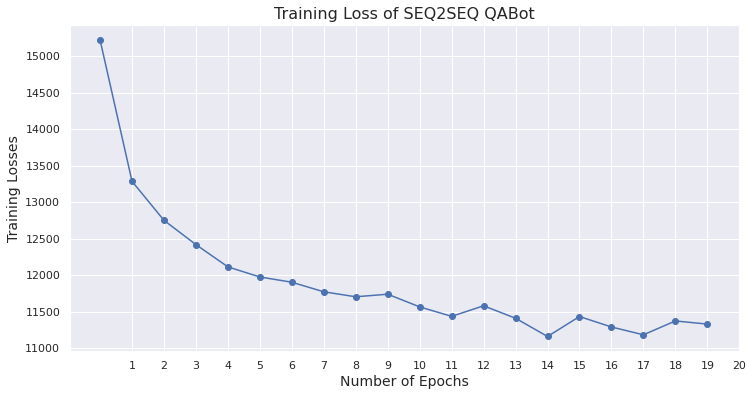

In [ ]:
"""
Seq2seq ChatBot Training Losses
"""
sns.set(style='darkgrid') 
plt.figure(figsize=(12,6))
plt.plot(loaded_results_df['train loss'], 'b-o') 
plt.title("Training Loss of SEQ2SEQ QABot", fontsize=16)
plt.xlabel('Number of Epochs', fontsize=14)
plt.xticks(range(1,21))
plt.ylabel('Training Losses', fontsize=14)
plt.show()

## **Loading Best Model**

In [ ]:
"""
Load State Dict of Best Model
"""
checkpoint_dict = torch.load(checkpointFileBestModel)
seq2seq_model.load_state_dict(checkpoint_dict['model_state_dict'])

seq2seq_model = seq2seq_model.eval().cpu()

##**Evaluation : Test Results**


## **Plot Prediction With Attention**

[colormap](https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html)

* The attention mechanism tells input words were considered important for predicting each output word at each time step $t$

* To understand whether the model is learning something reasonable written `plot_prediction_with_attention` function which takes in an question, predict the answer and show the prediction,the true answer and plot the attention scores if asked for plotting the same.

In [ ]:
getWords = lambda x : [idx2vocab[idx] for idx in x.cpu().numpy()]

def plot_prediction_with_attention(idx,plot_attention=True):
    
    question_tensor, answer_tensor = test_dataset[idx]
    
    with torch.no_grad():
        predictions, attention_score = seq2seq_model(question_tensor.unsqueeze(0))
        pred = torch.argmax(predictions, dim=2)

    
    question_s, answer_s, pred_ans = " ".join(getWords(question_tensor)), " ".join(getWords(answer_tensor)), " ".join(getWords(pred[0,:]))
    print("Question :     ", question_s, "\nAnswer :    ", answer_s,"\nPredicted : ", pred_ans)
    
    if plot_attention:
        question, pred_answer, attn_score = question_s.split(" "), pred_ans.split(" "), attention_score.T.cpu().numpy()

        fig, axis = plt.subplots(figsize=(15,10))
        matrix_plot = axis.pcolor(attn_score, cmap='twilight')
        axis.set_xticklabels(pred_answer, minor=False, rotation='vertical')
        axis.set_yticklabels(question, minor=False)
        axis.xaxis.tick_top()
        axis.set_xticks(np.arange(attn_score.shape[1]) + 0.5, minor=False)
        axis.set_yticks(np.arange(attn_score.shape[0]) + 0.5, minor=False)
        axis.invert_yaxis()
        plt.colorbar(matrix_plot)
        plt.show()

In [ ]:
print("*"*15)
print("Predictions :")
print("*"*15)

for i in [12,15,18,20,22,34,88,98,95,100]:
  plot_prediction_with_attention(i, False)
  print("*"*100,"\n\n")

***************
Predictions :
***************
Question :      <SOS> dear after the first <hashtag> update, my battery wasnt happy, after the second she got pissed  times a day my phone shut down and only going on with a charger in it  help  <hashtag> <EOS> 
Answer :     we're sorry to hear you're having issues with battery life and we're here to help  to start, you're currently on ios   additionally, do you have any apps that need updates in the app store  if so, we'd recommend updating them then test battery life again  <EOS> 
Predicted :  we want to help  send us a dm and we can look into this with you  <url> <EOS>  
**************************************************************************************************** 


Question :      <SOS> yall charged my account $16 99 for absolutely nothing  run me my refund please <EOS> 
Answer :     we'd be happy to get you pointed in the right direction  you'll want to reach out to our itunes team here: <url> <EOS> 
Predicted :  we'd like to he

In [ ]:
print("*"*15)
print("Predictions :")
print("*"*15)

for i in [12,15,18,20,22,34,88,98,95,100]:
  plot_prediction_with_attention(i, False)
  print("*"*100,"\n\n")

***************
Predictions :
***************
Question :      <SOS> dear after the first <hashtag> update, my battery wasnt happy, after the second she got pissed  times a day my phone shut down and only going on with a charger in it  help  <hashtag> <EOS> 
Answer :     we're sorry to hear you're having issues with battery life and we're here to help  to start, you're currently on ios   additionally, do you have any apps that need updates in the app store  if so, we'd recommend updating them then test battery life again  <EOS> 
Predicted :  we want to help  dm us and we'll look into this with you  <url> <EOS>     
**************************************************************************************************** 


Question :      <SOS> yall charged my account $16 99 for absolutely nothing  run me my refund please <EOS> 
Answer :     we'd be happy to get you pointed in the right direction  you'll want to reach out to our itunes team here: <url> <EOS> 
Predicted :  we want to help  dm 

Question :      <SOS> dear after the first <hashtag> update, my battery wasnt happy, after the second she got pissed  times a day my phone shut down and only going on with a charger in it  help  <hashtag> <EOS>
Answer :     we're sorry to hear you're having issues with battery life and we're here to help  to start, you're currently on ios   additionally, do you have any apps that need updates in the app store  if so, we'd recommend updating them then test battery life again  <EOS>
Predicted :  we'd like to help  send us a dm and we can take a look at this  <url> <EOS>  


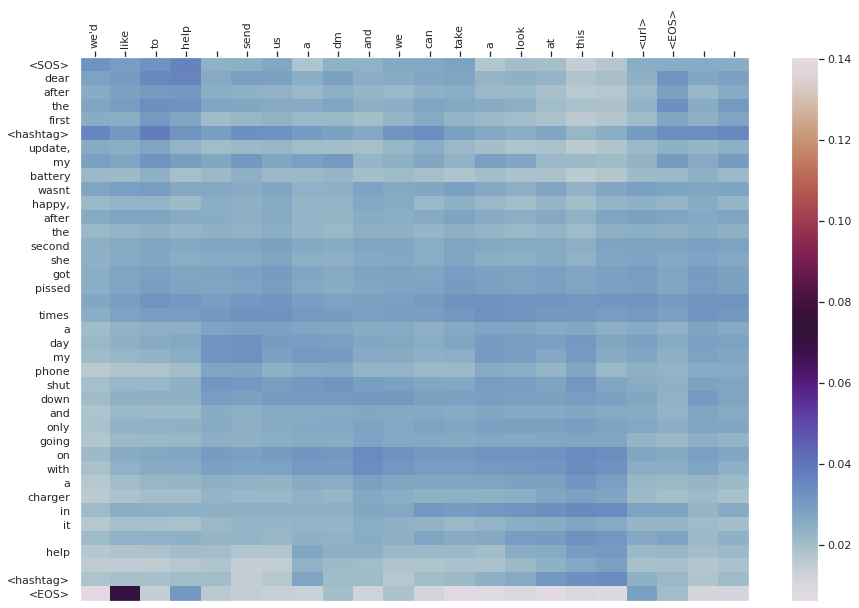

In [ ]:
plot_prediction_with_attention(12)

Question :      <SOS> upgrade to ios on calendars my up coming event doesnt so  what should i do <EOS> 
Answer :     let's look into that  send us a dm and we'll go from there  <url> <EOS> 
Predicted :  we want to help  dm us and we'll continue there  <url> <EOS>   <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


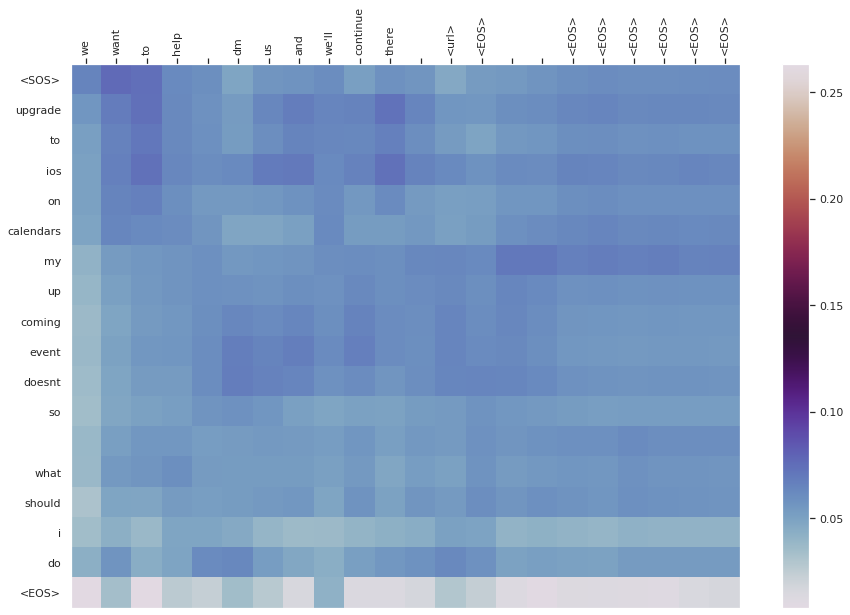

In [ ]:
plot_prediction_with_attention(15)

Question :      <SOS> yall need to fix this update bc my music randomly pauses and it skips my music please fix this <EOS>
Answer :     let us help with your music  send us a dm so we can take a closer look  <url> <EOS>
Predicted :  we want to help  which device are you using  which version of ios are you running  <EOS>  


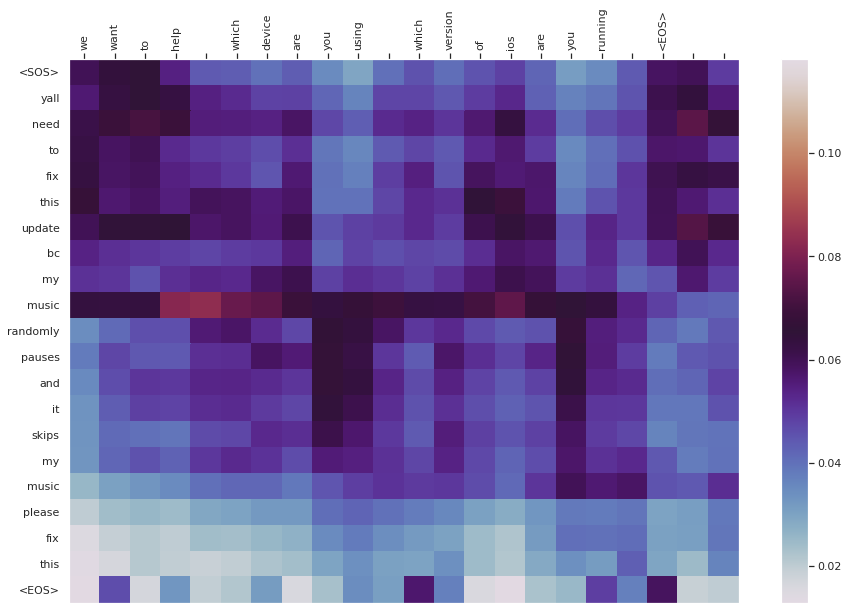

In [ ]:
plot_prediction_with_attention(20)

Question :      <SOS> "your iphone could not be activated because the activation server cannot be reached " <url> <EOS>
Answer :     we'd love to help you get your iphone activated  check out this article for steps to move things along: <url> <EOS>
Predicted :  we can help  to start, dm us the country you're in  <url> <EOS>  <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


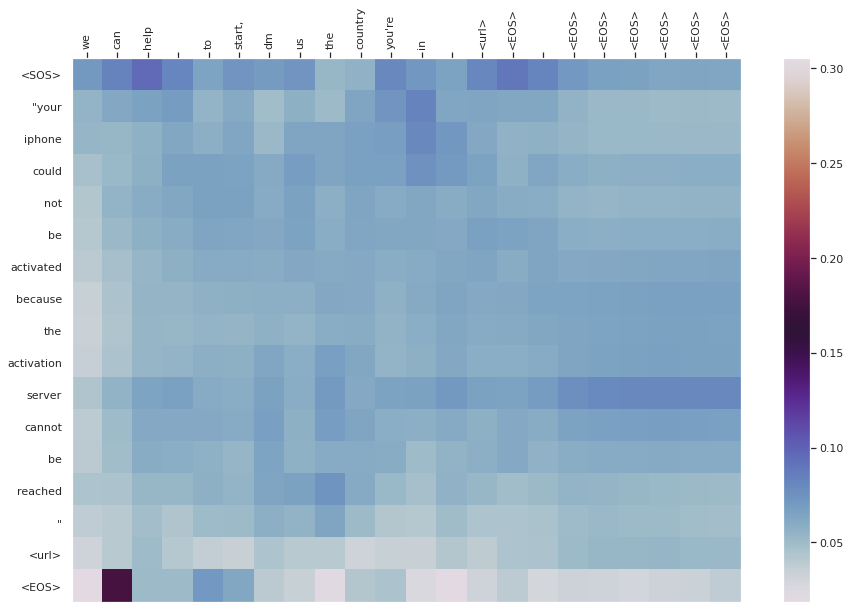

In [ ]:
plot_prediction_with_attention(22)

Question :      <SOS> Yes tried a new chord and wall adapter still nothing <EOS> 
Answer :     Let's run through all the steps here: <url> Let us know if these work for you. <EOS> 
Predicted :  Thanks for letting us know. Let's continue in DM. <url> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS> <EOS>


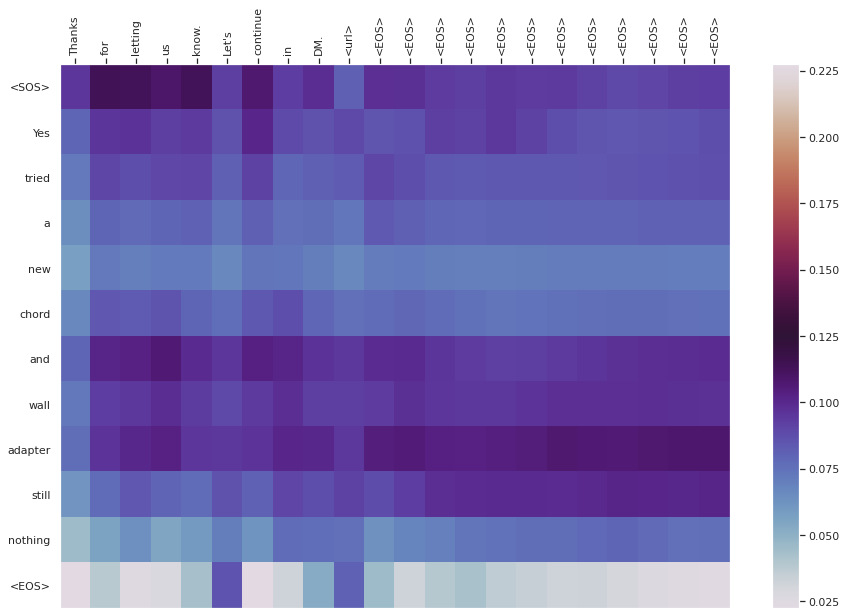

In [ ]:
plot_prediction_with_attention(32)

Question :      <SOS> thanks for creating an update that deleted every single memory i had from high school, college and the beginning of my career... <EOS> 
Answer :     We're happy to help where we can. DM us the details of what happened and we'll get started. <url> <EOS> 
Predicted :  We want to help. Send us a DM with more details about the issue you're experiencing and we'll go from there. <url>


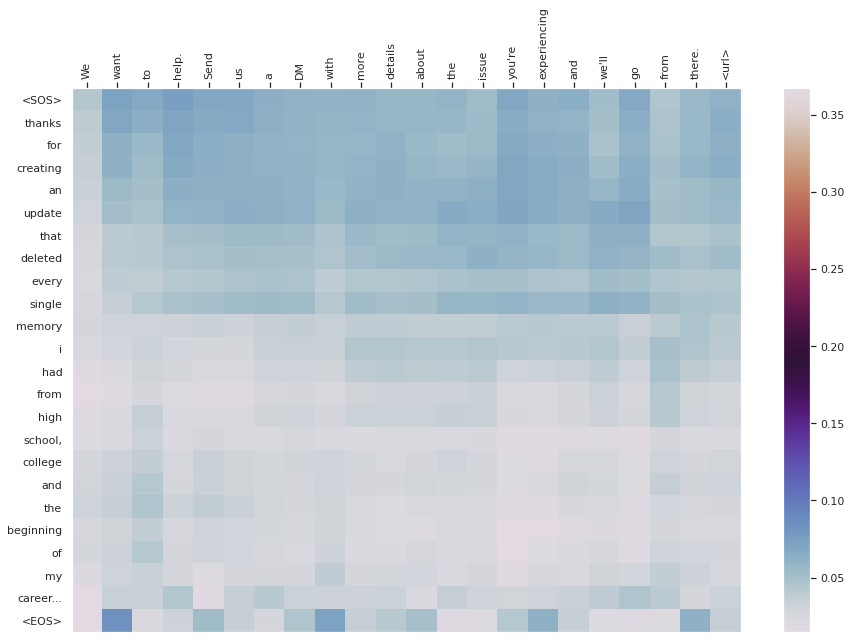

In [ ]:
plot_prediction_with_attention(35)